# Machine Learning in *sklearn* and *TensorFlow*: Data Exploration and Model Fitting

This notebook demonstrates a potential workflow for data exploration and Machine Learning model creation in Python using *sklearn* and *TensorFlow / Keras*.

## Data Exploration

This section contains several methods for the descriptive statistical analysis of datasets.
Purpose: exploration and preparation of data for modeling.

The script loads the Boston House Prices dataset from the *sklearn* package per default.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load demo dataset
from sklearn.datasets import load_boston
dataset = load_boston()

## First check of data
*Print dataset description (only if available):*

In [3]:
if hasattr(dataset, 'DESCR'):
    print(dataset['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

*Convert dataset to Pandas DataFrame (DF), add target data as new column, and check DF head:*

In [4]:
data_df = pd.DataFrame(data=dataset['data'])
if hasattr(dataset, 'feature_names'):
    data_df.columns=dataset['feature_names']
else:
    print("Please specify the feature names manually!")
data_df['TARGET'] = dataset['target']
print(data_df.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  TARGET  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


*Print DF statistics:*
- distribution of data
- sample count
- type of data

In [5]:
data_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
TARGET     506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


*Count null values per feature:*

In [7]:
# count null values per feature:
print(data_df.isnull().sum())

# drop null values if present:
unprocessed_length = len(data_df)
data_df = data_df.dropna()
processed_length = len(data_df)
print(f"\nUnprocessed DF length: {unprocessed_length}, processed DF length: {processed_length}, dropped instances: {unprocessed_length - processed_length}.")

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
TARGET     0
dtype: int64

Unprocessed DF length: 506, processed DF length: 506, dropped instances: 0.


Here, we eliminate all rows containing null values. It may sometimes be useful to replace some of the values by standard values instead to keep the rows for data fitting.

*Correlation/distribution preview:*

Plot Scatter Matrix of Data (visualization of correlations and distributions for each feature combination):

<Figure size 432x288 with 0 Axes>

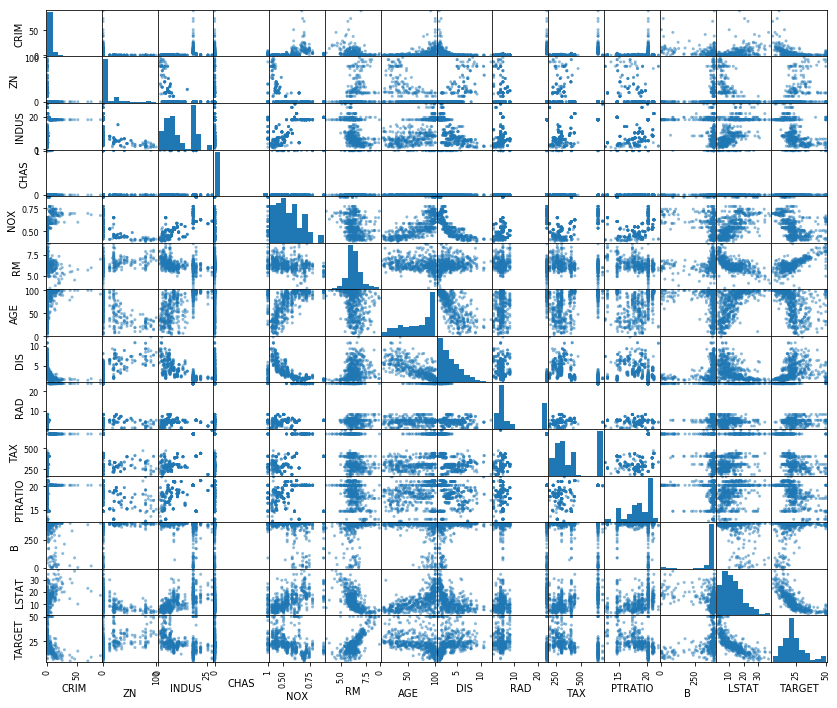

In [8]:
fig = plt.figure()
pd.plotting.scatter_matrix(data_df, figsize=((14, 12)))
plt.show()

*Create correlation matrix and plot it as a heatmap:*
- highly (positively or negatively) correlated features may contain redundant information - potential targets for removal for more efficient modeling / predictions
- desired: features with a high correlation to the target

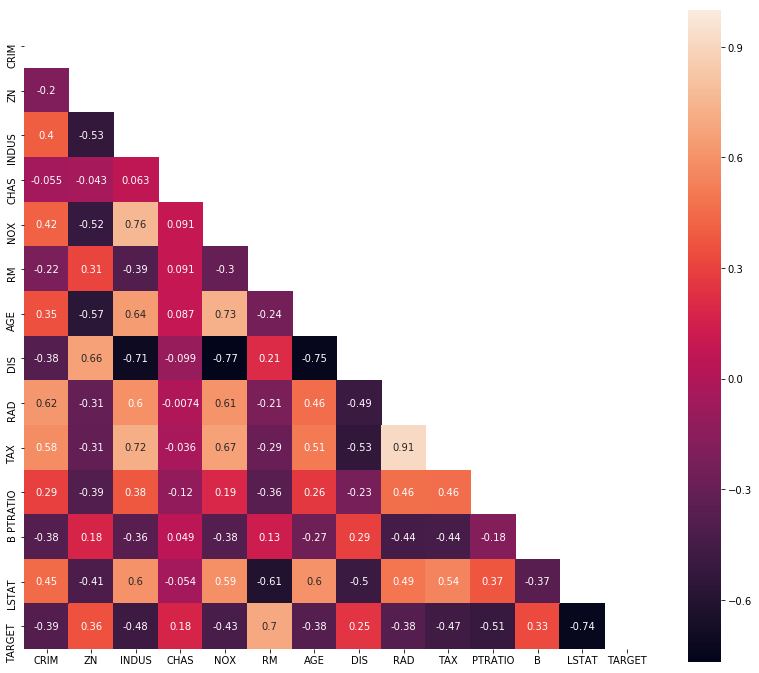

In [9]:
correlations = data_df.corr()

# show only the lower left triangle of the heatmap (avoid duplicate values):
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 12))
sns.heatmap(correlations, square=True, annot=True, mask=mask)  # switch off annot to hide the values
plt.show()

We could, e.g., use this information to eliminate features with a very low correlation to the target. We will, however, proceed with all features in this example.

*Plot distribution information:*

Issues with the distribution may lead to problems during model fitting. This may be compensated by data transformation and/or under-/oversampling of data.

- a) box and whisker plot
- b) histograms

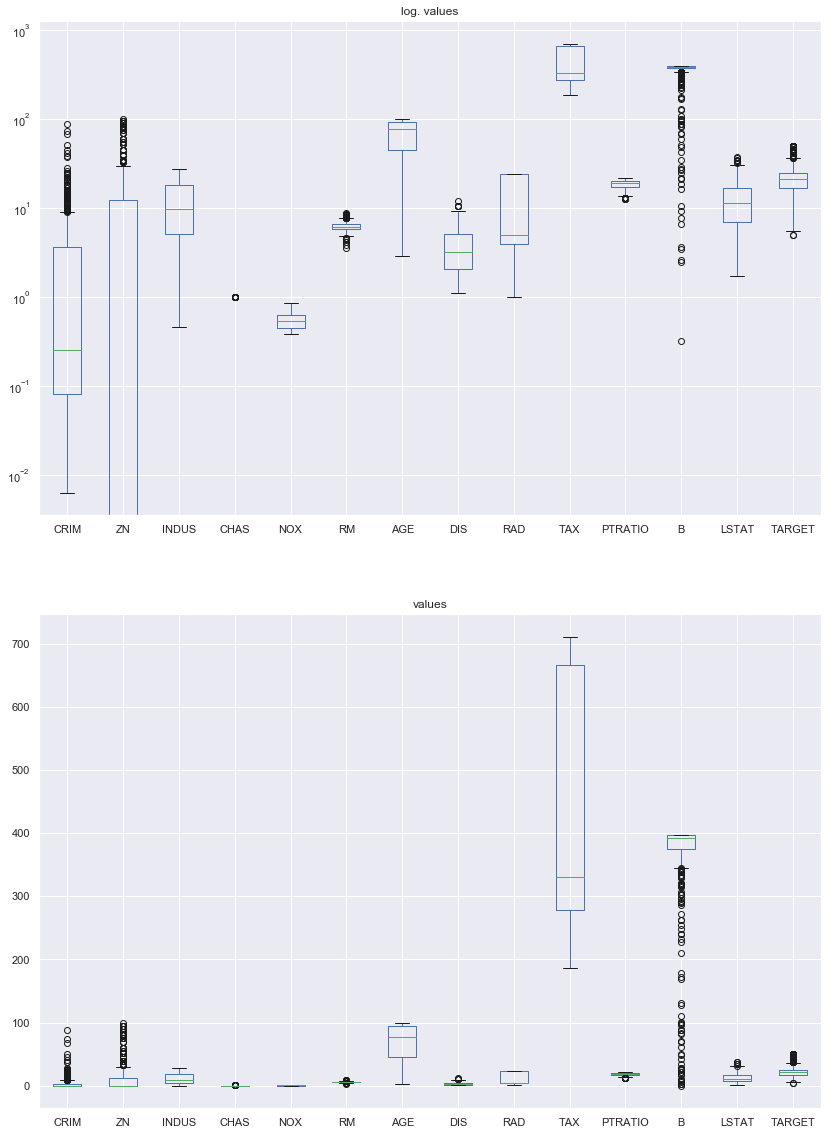

In [10]:
# a) box and whisker plot
sns.set()  # use Seaborn Standard Formatting from here on

fig, ax = plt.subplots(2, 1)
data_df.plot(kind='box', logy=True, figsize=(14,20), ax=ax[0], title='log. values')
data_df.plot(kind='box', logy=False, figsize=(14,20), ax=ax[1], title='values')
plt.show()

<Figure size 432x288 with 0 Axes>

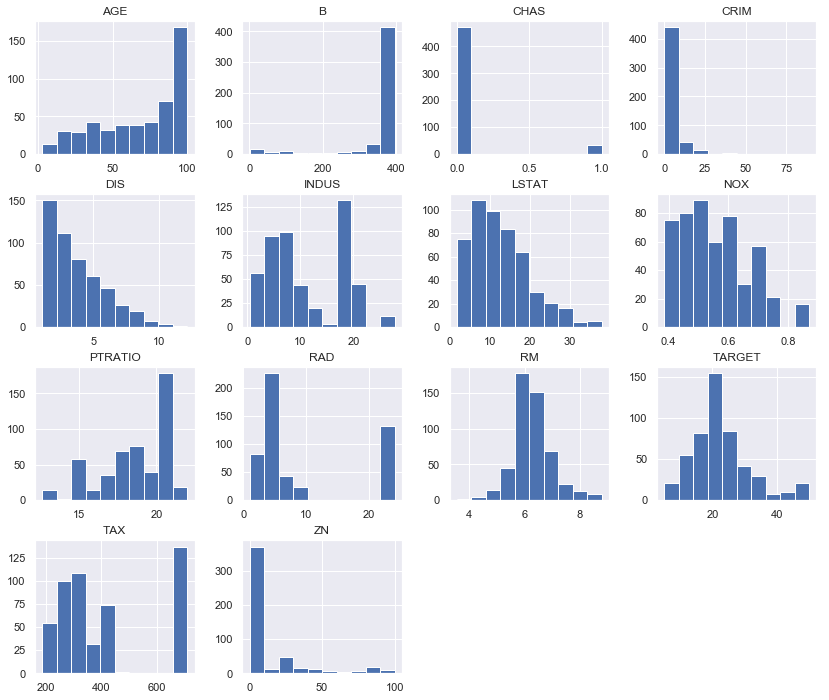

In [11]:
# b) histograms
fig = plt.figure()
data_df.hist(figsize=(14, 12))
plt.show()

No actions will be performed on the dataset in this demonstration.

## Data preprocessing, model creation, and model fit

The following steps create the actual model and fit it to the data. The workflow assumes that the target is numeric, i.e., Regressor Models will be used for the fit.

Two models will be used:
- Random Forest Regressor (i.e., an ensemble of multiple Decision Trees)
- K-nearest Neighbors Regressor

In [12]:
# import scikit learn packages:
# data preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# models:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsRegressor as KNR

*Shuffle the DataFrame and split it into 20% Test Set and 80% Training Set.*

In [13]:
data_df = shuffle(data_df)
train_df, test_df = train_test_split(data_df, test_size=0.2)

# split dataframes into features and targets:
if hasattr(dataset, 'feature_names'):
    train_data = train_df[dataset['feature_names']]
    test_data = test_df[dataset['feature_names']]
else:
    print("Please provide the feature names manually!")
    
train_target = train_df['TARGET']
test_target = test_df['TARGET']

# create dictionary for the results of fitting and scoring:
res_dict = {}

*Creation of and fit to the Random Forest Regressor:*

In [14]:
# screening parameters - in this demonstration, the number of estimators and the tree depth will be varied:
n_estimators = [20, 50, 100]
max_depths = [2, 5, 10, 20]

for n_est in n_estimators:
    for max_dep in max_depths:
        current_identifier = f"RFR model (n_estimators: {n_est}, max_depth: {max_dep})"
        RFR_model = RFR(n_estimators=n_est, max_depth=max_dep)
        RFR_model.fit(train_data, train_target)
        train_score = RFR_model.score(train_data, train_target)
        test_score = RFR_model.score(test_data, test_target)
        res_dict[current_identifier] = {'model': RFR_model, 'train score': train_score, 'test score': test_score}

*Creation of and fit to the K-nearest Neighbors Regressor:*

In [15]:
# screening parameters - in this demonstration, only the number of neighbors will be varied:
n_neighbors = [2, 3, 5, 10]

for n_n in n_neighbors:
    current_identifier = f"KNR model (n_neighbors: {n_n})"
    KNR_model = KNR(n_neighbors=n_n)
    KNR_model.fit(train_data, train_target)
    train_score = KNR_model.score(train_data, train_target)
    test_score = KNR_model.score(test_data, test_target)
    res_dict[current_identifier] = {'model': KNR_model, 'train score': train_score, 'test score': test_score}

*Iterate through results dictionary and create a results DataFrame:*

In [16]:
res_df = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score'])

for key, value in res_dict.items():
    res_df = res_df.append({'Model': key,
                            'Test Score': round(res_dict[key]['test score'], 2),
                            'Train Score': round(res_dict[key]['train score'], 2)}, ignore_index=True)

# sort values by Test Score in descending order:
res_df.sort_values(by='Test Score', ascending=False, inplace=True)
res_df.reset_index(drop=True, inplace=True)

# print results:
print(res_df)

                                           Model  Train Score  Test Score
0    RFR model (n_estimators: 20, max_depth: 20)         0.98        0.88
1   RFR model (n_estimators: 100, max_depth: 20)         0.98        0.88
2    RFR model (n_estimators: 20, max_depth: 10)         0.98        0.87
3     RFR model (n_estimators: 20, max_depth: 5)         0.93        0.86
4    RFR model (n_estimators: 50, max_depth: 10)         0.98        0.86
5    RFR model (n_estimators: 50, max_depth: 20)         0.98        0.86
6   RFR model (n_estimators: 100, max_depth: 10)         0.98        0.86
7    RFR model (n_estimators: 100, max_depth: 5)         0.94        0.85
8     RFR model (n_estimators: 50, max_depth: 5)         0.93        0.83
9    RFR model (n_estimators: 100, max_depth: 2)         0.77        0.80
10    RFR model (n_estimators: 20, max_depth: 2)         0.76        0.79
11    RFR model (n_estimators: 50, max_depth: 2)         0.76        0.79
12                    KNR model (n_nei

### Feature Importance:

*Create a plot of the Feature Importance based on the best-performing Random Forest Regressor:*

The Feature Importance denotes the proportion of the Target determined by the respective Feature.

<Figure size 432x288 with 0 Axes>

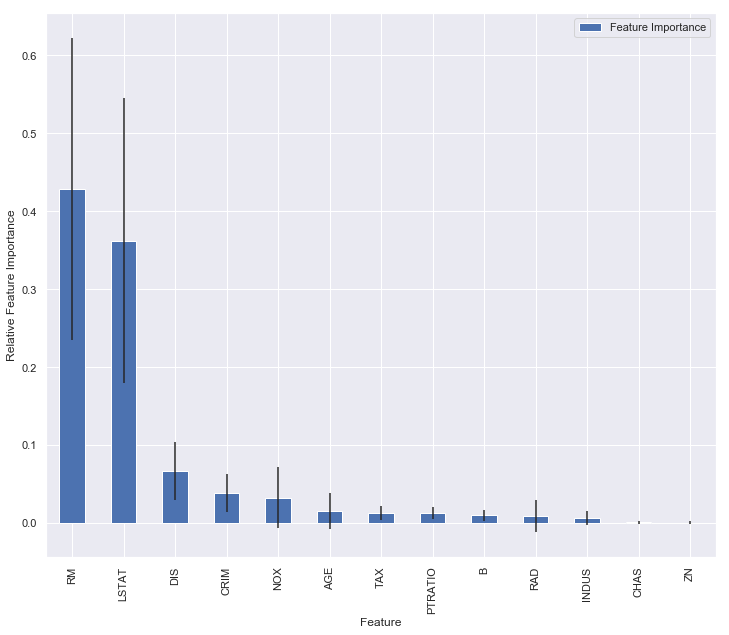

DataFrame of Feature Importance:

          Feature Importance     Stdev
RM                 0.428982  0.193748
LSTAT              0.362468  0.182349
DIS                0.066468  0.037340
CRIM               0.038289  0.024545
NOX                0.032736  0.038744
AGE                0.016230  0.023066
TAX                0.013564  0.008836
PTRATIO            0.013029  0.007930
B                  0.010114  0.006795
RAD                0.009586  0.020655
INDUS              0.006546  0.008682
CHAS               0.001078  0.001584
ZN                 0.000910  0.001427


In [17]:
# isolate identifier of best-performing Random Forest Regressor model:
for ind, row in res_df.iterrows():
    if 'RFR model' in row['Model']:
        identifier = row['Model']
        break

# isolate feature importances from model and create dictionary based on these values:
feature_imp_dict = dict(zip(dataset['feature_names'], res_dict[identifier]['model'].feature_importances_))
# isolate standard deviation for each feature importance across all tree models of the random forest:
std = np.std([tree.feature_importances_ for tree in res_dict[identifier]['model'].estimators_],
             axis=0)

# convert dictionary to DataFrame:
imp_df = pd.DataFrame.from_dict(data=feature_imp_dict, orient='index')
imp_df.columns = ['Feature Importance']
imp_df['Stdev'] = std

# sort values in descending order:
imp_df.sort_values(by='Feature Importance', inplace=True, ascending=False)

# create plot:
fig = plt.figure()
imp_df.plot.bar(figsize=(12, 10), yerr='Stdev')
plt.ylabel('Relative Feature Importance')
plt.xlabel('Feature')
plt.show()

# print Feature Importance DataFrame:
print("DataFrame of Feature Importance:\n\n", imp_df)

## Model Tuning based on Feature Importance

We will tune the RFR model by the *SelectFromModel* functionality of *scikit-learn*.

In [18]:
from sklearn.feature_selection import SelectFromModel

feature_selector_model = SelectFromModel(res_dict[identifier]['model'], prefit=True)  # using the RFR model selected above

# recompute the feature DF based on the important features:
initial_feature_number = len(train_data.iloc[0])
train_data_opt = feature_selector_model.transform(train_data)
test_data_opt = feature_selector_model.transform(test_data)
new_feature_number = len(train_data_opt[0])  # the procedure results in a numpy array

print(f"The number of features was reduced from {initial_feature_number} to {new_feature_number} based on Feature Importance.")

# refit a RFR model to the optimized datasets:
n_estimators = [20, 50, 100]
max_depths = [2, 5, 10, 20]
opt_RFR_dict = {}

for n_est in n_estimators:
    for max_dep in max_depths:
        current_identifier = f"optimized RFR model (n_estimators: {n_est}, max_depth: {max_dep})"
        RFR_model = RFR(n_estimators=n_est, max_depth=max_dep)
        RFR_model.fit(train_data_opt, train_target)
        train_score = RFR_model.score(train_data_opt, train_target)
        test_score = RFR_model.score(test_data_opt, test_target)
        opt_RFR_dict[current_identifier] = {'model': RFR_model, 'train score': train_score, 'test score': test_score}

# identify best-performing optimized RFR model:
test_score = 0
for key, value in opt_RFR_dict.items():
    if opt_RFR_dict[key]['test score'] > test_score:
        best_model = opt_RFR_dict[key]['model']
        test_score = opt_RFR_dict[key]['test score']
        train_score = opt_RFR_dict[key]['train score']
        parameters = key

print(f"\nThe optimized RFR model (parameters: {parameters}) yielded a score of {round(test_score, 2)} on the test dataset and a score of {round(train_score, 2)} on the train dataset.")

The number of features was reduced from 13 to 2 based on Feature Importance.

The optimized RFR model (parameters: optimized RFR model (n_estimators: 20, max_depth: 2)) yielded a score of 0.79 on the test dataset and a score of 0.77 on the train dataset.


### Use the best-performing model for predictions:

In [19]:
# load model and print model properties:
best_model = res_dict[res_df.iloc[0]['Model']]['model']
print(f"Best-performing model: {res_df.iloc[0]['Model']}.\nModel properties:\n {best_model}")

Best-performing model: RFR model (n_estimators: 20, max_depth: 20).
Model properties:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [20]:
# using the best-performing model for predictions:
# use first DF row as demo test dataset; replace this row by actual data for real predictions
test_dataset = np.array(data_df.iloc[0][:-1].values.reshape(1, -1))  
prediction = best_model.predict(test_dataset)  # provide data in form of an array
print(f"Features:\n{test_dataset}\n\n Model prediction: {prediction[0]}")

Features:
[[3.5233e-01 0.0000e+00 2.1890e+01 0.0000e+00 6.2400e-01 6.4540e+00
  9.8400e+01 1.8498e+00 4.0000e+00 4.3700e+02 2.1200e+01 3.9408e+02
  1.4590e+01]]

 Model prediction: 17.145


## Creating and fitting a Deep Neural Network using TensorFlow / Keras

Let's a simple TensorFlow Deep Neural Network to the data!

In [21]:
# import libraries:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import backend as ker_back
from keras.callbacks import EarlyStopping

input_number = len(train_data.iloc[0])  # number of features = number of inputs to the first layer

# create the model:
model = Sequential()

# let's add several fully connected layers to the model:
model.add(Dense(input_number, input_shape=(input_number,), activation='relu'))
model.add(Dense(input_number, activation='relu'))
model.add(Dense(int(input_number/2), activation='relu'))  # the number of neurons per layer is reduced from this layer downwards
model.add(Dense(output_dim=1))  # output layer: dimension is one, because we're dealing with a regression problem

# enable EarlyStopping, i.e., stop fitting at minimal validation loss, to avoid over-fitting of the model:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# compile the model:
model.compile(loss='mean_squared_error',  # optimize by mean-squared error
              optimizer='adam')

# fit model:
# we are going to train for 500 epochs, i.e., cycle through our dataset 500 times (unless early stopping is triggered):
fit_data = model.fit(train_data, train_target, batch_size=16, epochs=500, validation_data=(test_data, test_target),
                     callbacks=[early_stopping])

C:\Users\forkfighter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\forkfighter\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 404 samples, validate on 102 samples
Epoch 1/500
404/404 [==============================] - 1s 3ms/step - loss: 68.2325 - val_loss: 74.1996
Epoch 2/500
404/404 [==============================] - 0s 114us/step - loss: 66.6625 - val_loss: 68.1109
Epoch 3/500
404/404 [==============================] - 0s 119us/step - loss: 63.5535 - val_loss: 66.0829
Epoch 4/500
404/404 [==============================] - 0s 148us/step - loss: 61.8225 - val_loss: 64.7436
Epoch 5/500
404/404 [==============================] - 0s 126us/step - loss: 62.0099 - val_loss: 64.3417
Epoch 6/500
404/404 [==============================] - 0s 119us/step - loss: 59.9594 - val_loss: 63.6038
Epoch 7/500
404/404 [==============================] - 0s 109us/step - loss: 58.9564 - val_loss: 61.4578
Epoch 8/500
404/404 [==============================] - 0s 129us/step - loss: 59.0026 - val_loss: 62.4685
Epoch 9/500
404/404 [==============================] - 0s 124us/step - loss: 57.7408 - val_loss: 62.2978
Epoch 10/50

Epoch 78/500
404/404 [==============================] - 0s 163us/step - loss: 21.3482 - val_loss: 23.3693
Epoch 79/500
404/404 [==============================] - 0s 124us/step - loss: 21.3533 - val_loss: 22.5772
Epoch 80/500
404/404 [==============================] - 0s 119us/step - loss: 23.6285 - val_loss: 23.3723
Epoch 81/500
404/404 [==============================] - 0s 131us/step - loss: 23.9346 - val_loss: 22.1301
Epoch 82/500
404/404 [==============================] - 0s 116us/step - loss: 20.8840 - val_loss: 22.9556
Epoch 83/500
404/404 [==============================] - 0s 126us/step - loss: 21.5518 - val_loss: 23.0059
Epoch 84/500
404/404 [==============================] - 0s 124us/step - loss: 21.3323 - val_loss: 23.0918
Epoch 85/500
404/404 [==============================] - 0s 119us/step - loss: 21.2377 - val_loss: 22.3731
Epoch 86/500
404/404 [==============================] - 0s 121us/step - loss: 22.3956 - val_loss: 23.0882
Epoch 87/500
404/404 [========================

Epoch 155/500
404/404 [==============================] - 0s 124us/step - loss: 18.7612 - val_loss: 19.9397
Epoch 156/500
404/404 [==============================] - 0s 114us/step - loss: 18.3989 - val_loss: 20.0727
Epoch 157/500
404/404 [==============================] - 0s 124us/step - loss: 17.1417 - val_loss: 20.7523
Epoch 00157: early stopping


*Visualize model training:*

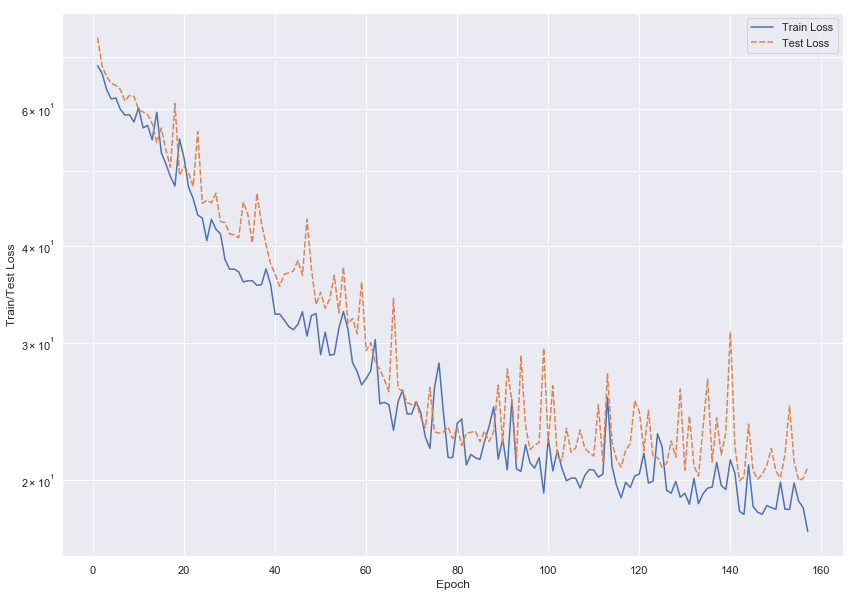

In [22]:
# requires seaborn version >= 0.9

# isolate data and create DataFrame:
train_loss = fit_data.history['loss']
test_loss = fit_data.history['val_loss']
epochs = np.arange(1, len(train_loss)+1)
fit_data_df = pd.DataFrame(data=np.column_stack((train_loss, test_loss)), columns=['Train Loss', 'Test Loss'],
                           index=epochs)

# create plot:
fig = plt.figure(figsize=(14, 10))
sns.lineplot(data=fit_data_df)
plt.yscale('log')  # set log scale for y axis
plt.xlabel('Epoch')
plt.ylabel('Train/Test Loss')
plt.grid(True, which='both')  # activate major and minor grid
plt.show()

*Evaluate Deep Neural Network performance:*

In [23]:
# evaluate deep neural network result based on the scikit-learn R^2 regression metric:
from sklearn.metrics import r2_score

# get predictions:
test_pred_target = model.predict(test_data)
train_pred_target = model.predict(train_data)
# get scores:
dnn_test_score = r2_score(test_target, test_pred_target)
dnn_train_score = r2_score(train_target, train_pred_target)

# print evaluation result:
print(f"\nResult of Deep Neural Network fitting: Test Score: {round(dnn_test_score, 2)}, Train Score: {round(dnn_train_score, 2)}.")


Result of Deep Neural Network fitting: Test Score: 0.72, Train Score: 0.81.


*Save the model for later use:*

In [24]:
model.save('./dnn-model.sav')
# use model.load('filepath') for loading of saved models